# Hail Storm Visualization Using Py-ART and Pandas!

Within this post, we will walk through how to combine radar and storm report data, creating an animation of the two!

## Motivation

On September 7, 2021, a strong line of thunderstorms passed through Southern Wisconsin and Northern Illinois, leaving a trail of hail and wind damage in its path.

Here is a sample image of the storm reports and hail that was found near the Milwaukee/Madison area in Wisconsin



![Hail Image](https://www.weather.gov/images/mkx/events/2021/Sept_07_Hail/RecapOfSevereStorms.png)

We would like to add some more context here. Specifically, we would like to add reflectivity imagery from the NOAA radar network (NEXRAD), with corresponding storm reports paired in time.

This notebooks build upon a notebook Russ Schumacher from Colorado State Unversity put together for his class
- [Link to original notebook](https://github.com/russ-schumacher/ats641_spring2022/blob/master/example_notebooks/pyart_nexrad_maps_reports.ipynb)

## Imports

In [20]:
from datetime import datetime
import glob
from math import atan2 as atan2
import os
import tempfile
import warnings

import fsspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from metpy.plots import USCOUNTIES
import imageio
import numpy as np
import pandas as pd
import pyart
import nexradaws
import pytz

templocation = tempfile.mkdtemp()

warnings.filterwarnings("ignore")

## NEXRAD Data Access - fsspec
Let's start by taking a look at the radar data available from the NEXRAD (NOAA's weather radar network) archive on the Amazon Cloud.

We can use [`fsspec`](https://filesystem-spec.readthedocs.io/en/latest/), which is a Python package focused on working across different filesystems (ex. your local machine vs. the different clouds).

### Setup the Filesystem and Read From the Bucket
We start by setting up our Amazon bucket, setting anonymous access.

In [21]:
fs = fsspec.filesystem("s3", anon=True)

date = datetime(2021, 9, 7, 17)
site = "KMKX"

nexrad_path = date.strftime(f"s3://noaa-nexrad-level2/%Y/%m/%d/{site}/{site}%Y%m%d_%H*")
files = sorted(fs.glob(nexrad_path))
files

['noaa-nexrad-level2/2021/09/07/KMKX/KMKX20210907_170101_V06',
 'noaa-nexrad-level2/2021/09/07/KMKX/KMKX20210907_170739_V06',
 'noaa-nexrad-level2/2021/09/07/KMKX/KMKX20210907_171431_V06',
 'noaa-nexrad-level2/2021/09/07/KMKX/KMKX20210907_172123_V06',
 'noaa-nexrad-level2/2021/09/07/KMKX/KMKX20210907_172814_V06',
 'noaa-nexrad-level2/2021/09/07/KMKX/KMKX20210907_173452_V06',
 'noaa-nexrad-level2/2021/09/07/KMKX/KMKX20210907_174130_V06',
 'noaa-nexrad-level2/2021/09/07/KMKX/KMKX20210907_174807_V06',
 'noaa-nexrad-level2/2021/09/07/KMKX/KMKX20210907_175459_V06',
 'noaa-nexrad-level2/2021/09/07/KMKX/KMKX20210907_175459_V06_MDM']

### Read in a File
Let's read the first file using `pyart.io.read_nexrad_archive`

In [22]:
radar = pyart.io.read_nexrad_archive("s3://" + files[0])

### Visualize the Dataset
We can start by visualizing the reflectivity field, which indicates heavy precipitation, with possibly hail!

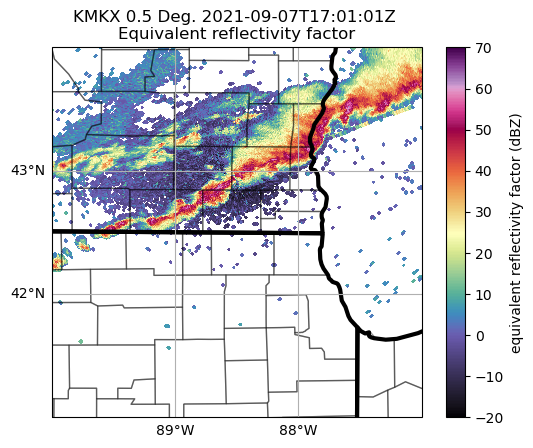

In [26]:
display = pyart.graph.RadarMapDisplay(radar)
ax = plt.subplot(111, projection=ccrs.PlateCarree())

ax.add_feature(cfeature.STATES, linewidth=3)
ax.add_feature(USCOUNTIES, alpha=0.4)

display.plot_ppi_map(
    "reflectivity",
    ax=ax,
    embellish=False,
    add_grid_lines=True,
    cmap="pyart_ChaseSpectral",
    vmin=-20,
    vmax=70,
)

ax.set_extent((-90, -87, 41, 44))

## Read in NEXRAD Data Using `nexradaws`
There is a package, `nexradaws`, which makes searching and downloading data from the cloud much easier!

Let's look at using this instead of scrolling the filesystem.

### Configure the Search
We need to specify which radar (in this case, we are interested in Milwaukee (KMKX), Wisconsin)

The storm moved through the region between 15 and 20 UTC on September 7, 2021.

We also set the minimum and maximum latitudes/longitudes to plot, based on the image above.

In [27]:
radar_id = "KMKX"
start = pd.Timestamp(2021, 9, 7, 15).tz_localize(tz="UTC")
end = pd.Timestamp(2021, 9, 7, 20).tz_localize(tz="UTC")


min_lon = -90
max_lon = -87
min_lat = 41
max_lat = 44

### Search and Download the Data
We will download the data in this case since we would like to store it for later!

In [28]:
# Configure the nexrad interface using our time and location
conn = nexradaws.NexradAwsInterface()
scans = conn.get_avail_scans_in_range(start, end, radar_id)
print("There are {} scans available between {} and {}\n".format(len(scans), start, end))

# Download the files
results = conn.download(scans, templocation)

There are 54 scans available between 2021-09-07 15:00:00+00:00 and 2021-09-07 20:00:00+00:00

Downloaded KMKX20210907_151132_V06
Downloaded KMKX20210907_152621_V06
Downloaded KMKX20210907_150152_V06
Downloaded KMKX20210907_151622_V06
Downloaded KMKX20210907_152121_V06
Downloaded KMKX20210907_150642_V06
Downloaded KMKX20210907_155424_V06_MDM
Downloaded KMKX20210907_153610_V06
Downloaded KMKX20210907_154814_V06
Downloaded KMKX20210907_155424_V06
Downloaded KMKX20210907_154205_V06
Downloaded KMKX20210907_160034_V06
Downloaded KMKX20210907_160607_V06
Downloaded KMKX20210907_161141_V06
Downloaded KMKX20210907_163532_V06
Downloaded KMKX20210907_161714_V06
Downloaded KMKX20210907_162924_V06
Downloaded KMKX20210907_164816_V06
Downloaded KMKX20210907_165433_V06
Downloaded KMKX20210907_165433_V06_MDM
Downloaded KMKX20210907_162247_V06
Downloaded KMKX20210907_171431_V06
Downloaded KMKX20210907_153134_V06
Downloaded KMKX20210907_170739_V06
Downloaded KMKX20210907_172814_V06
Downloaded KMKX20210907

## Read SPC Reports Using Pandas
Now that we have our radar data, we can add Storm Prediction Center (SPC) reports for additional context. The SPC reports are categorized by
- Wind
- Hail
- Tornado

In this case, there were wind and hail reports reported to the local National Weather Service office in Milwaukee, that are accesible in the SPC report archive.

The files are accesible via the internet using the following URL string
- `https://www.spc.noaa.gov/wcm/data/{year}_{category}.csv`

for example, the wind reports from 2021 can be found at
- [`https://www.spc.noaa.gov/wcm/data/2021_wind.csv`](https://www.spc.noaa.gov/wcm/data/2021_wind.csv)

### Setup a Function to Read the Reports
Since the only variable that changes is the category and year, we can configure a function to help us generalize the code!

In [29]:
def read_spc_reports(start_time, end_time, hazard, timezone="Etc/GMT+6"):
    """
    Reads in SPC report data remotely from the SPC
    archive


    ==========
    Parameters
    ==========
    start_time: datetime.datetime, start time of interest
    end_time: datetime.datetime, end time of interest
    hazard: str, hazard of interest (hail, wind, or torn)
    timezone: str, timezone of interest, default is US central time

    ==========
    Returns
    ==========
    df: pandas.DataFrame with the data
    """

    # Read in the reports from the SPC archive
    reports = pd.read_csv(
        f"https://www.spc.noaa.gov/wcm/data/{start_time.year}_{hazard}.csv"
    )

    # Conver to datetime using the date and time columns
    reports["datetime"] = pd.to_datetime(reports.date + " " + reports.time)
    reports.set_index("datetime", inplace=True)

    # Convert from local time to UTC time
    reports.index = reports.index.tz_localize(
        timezone, ambiguous="NaT", nonexistent="shift_forward"
    ).tz_convert("UTC")

    # Subset down to 30 minutes before/after the radar times we're plotting
    reports[
        ((start_time - pd.Timedelta(minutes=30)).strftime("%Y-%m-%d %H:%M")) : (
            (end_time + pd.Timedelta(minutes=30)).strftime("%Y-%m-%d %H:%M")
        )
    ]

    return reports

#### Read in the Reports
Now that we have our function, we can read in the reports and assign to different dataframes!

In [30]:
wind_reports = read_spc_reports(start, end, "wind")
tornado_reports = read_spc_reports(start, end, "torn")
hail_reports = read_spc_reports(start, end, "hail")
hail_reports

,om,yr,mo,dy,date,time,tz,st,stf,stn,...,elon,len,wid,ns,sn,sg,f1,f2,f3,f4
datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-06 17:53:00+00:00,657521,2021,1,6,2021-01-06,11:53:00,3,TX,48,0,...,-96.7500,0,0,0,0,0,331,0,0,0
2021-01-06 23:31:00+00:00,657522,2021,1,6,2021-01-06,17:31:00,3,TX,48,0,...,-95.4300,0,0,0,0,0,39,0,0,0
2021-01-07 00:05:00+00:00,657523,2021,1,6,2021-01-06,18:05:00,3,TX,48,0,...,-95.0500,0,0,0,0,0,167,0,0,0
2021-01-07 00:21:00+00:00,657524,2021,1,6,2021-01-06,18:21:00,3,TX,48,0,...,-95.0200,0,0,0,0,0,167,0,0,0
2021-01-24 18:00:00+00:00,657525,2021,1,24,2021-01-24,12:00:00,3,AZ,4,0,...,-111.1595,0,0,0,0,0,19,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-30 21:45:00+00:00,663777,2021,12,30,2021-12-30,15:45:00,3,SC,45,0,...,-80.0100,0,0,0,0,0,15,0,0,0
2021-12-30 22:05:00+00:00,663778,2021,12,30,2021-12-30,16:05:00,3,SC,45,0,...,-80.1800,0,0,0,0,0,35,0,0,0
2021-12-30 22:10:00+00:00,663779,2021,12,30,2021-12-30,16:10:00,3,SC,45,0,...,-80.2200,0,0,0,0,0,35,0,0,0


## Loop Through and Plot the Radar and Reports
Let's put it all together! We can loop through and plot the radar image with corresponding wind reports.

### Setup a Helper Function to Create a Scale Bar

In [31]:
def gc_latlon_bear_dist(lat1, lon1, bear, dist):
    """
    Input lat1/lon1 as decimal degrees, as well as bearing and distance from
    the coordinate. Returns lat2/lon2 of final destination. Cannot be
    vectorized due to atan2.
    """
    re = 6371.1  # km
    lat1r = np.deg2rad(lat1)
    lon1r = np.deg2rad(lon1)
    bearr = np.deg2rad(bear)
    lat2r = np.arcsin(
        (np.sin(lat1r) * np.cos(dist / re))
        + (np.cos(lat1r) * np.sin(dist / re) * np.cos(bearr))
    )
    lon2r = lon1r + atan2(
        np.sin(bearr) * np.sin(dist / re) * np.cos(lat1r),
        np.cos(dist / re) - np.sin(lat1r) * np.sin(lat2r),
    )
    return np.rad2deg(lat2r), np.rad2deg(lon2r)


def add_scale_line(
    scale, ax, projection, color="k", linewidth=None, fontsize=None, fontweight=None
):
    """
    Adds a line that shows the map scale in km. The line will automatically
    scale based on zoom level of the map. Works with cartopy.

    Parameters
    ----------
    scale : scalar
        Length of line to draw, in km.
    ax : matplotlib.pyplot.Axes instance
        Axes instance to draw line on. It is assumed that this was created
        with a map projection.
    projection : cartopy.crs projection
        Cartopy projection being used in the plot.

    Other Parameters
    ----------------
    color : str
        Color of line and text to draw. Default is black.
    """
    frac_lat = 0.15  # distance fraction from bottom of plot
    frac_lon = 0.5  # distance fraction from left of plot
    e1 = ax.get_extent()
    center_lon = e1[0] + frac_lon * (e1[1] - e1[0])
    center_lat = e1[2] + frac_lat * (e1[3] - e1[2])
    # Main line
    lat1, lon1 = gc_latlon_bear_dist(
        center_lat, center_lon, -90, scale / 2.0
    )  # left point
    lat2, lon2 = gc_latlon_bear_dist(
        center_lat, center_lon, 90, scale / 2.0
    )  # right point
    if lon1 <= e1[0] or lon2 >= e1[1]:
        warnings.warn(
            "Scale line longer than extent of plot! "
            + "Try shortening for best effect."
        )
    ax.plot(
        [lon1, lon2],
        [lat1, lat2],
        linestyle="-",
        color=color,
        transform=projection,
        linewidth=linewidth,
    )
    # Draw a vertical hash on the left edge
    lat1a, lon1a = gc_latlon_bear_dist(
        lat1, lon1, 180, frac_lon * scale / 20.0
    )  # bottom left hash
    lat1b, lon1b = gc_latlon_bear_dist(
        lat1, lon1, 0, frac_lon * scale / 20.0
    )  # top left hash
    ax.plot(
        [lon1a, lon1b],
        [lat1a, lat1b],
        linestyle="-",
        color=color,
        transform=projection,
        linewidth=linewidth,
    )
    # Draw a vertical hash on the right edge
    lat2a, lon2a = gc_latlon_bear_dist(
        lat2, lon2, 180, frac_lon * scale / 20.0
    )  # bottom right hash
    lat2b, lon2b = gc_latlon_bear_dist(
        lat2, lon2, 0, frac_lon * scale / 20.0
    )  # top right hash
    ax.plot(
        [lon2a, lon2b],
        [lat2a, lat2b],
        linestyle="-",
        color=color,
        transform=projection,
        linewidth=linewidth,
    )
    # Draw scale label
    ax.text(
        center_lon,
        center_lat - frac_lat * (e1[3] - e1[2]) / 4.0,
        str(int(scale)) + " km",
        horizontalalignment="center",
        verticalalignment="center",
        color=color,
        fontweight=fontweight,
        fontsize=fontsize,
    )

In [32]:
for i, scan in enumerate(results.iter_success(), start=1):
    ## skip the files ending in "MDM"
    if scan.filename[-3:] != "MDM":
        print("working on " + scan.filename)

        this_time = pd.to_datetime(
            scan.filename[4:17], format="%Y%m%d_%H%M"
        ).tz_localize("UTC")

        radar = scan.open_pyart()
        # display = pyart.graph.RadarDisplay(radar)

        fig = plt.figure(figsize=[15, 7])

        map_panel_axes = [0.05, 0.05, 0.4, 0.80]
        x_cut_panel_axes = [0.55, 0.10, 0.4, 0.25]
        y_cut_panel_axes = [0.55, 0.50, 0.4, 0.25]

        projection = ccrs.PlateCarree()

        ## apply gatefilter (see here: https://arm-doe.github.io/pyart/notebooks/masking_data_with_gatefilters.html)
        # gatefilter = pyart.correct.moment_based_gate_filter(radar)
        gatefilter = pyart.filters.GateFilter(radar)

        # Lets remove reflectivity values below a threshold.
        gatefilter.exclude_below("reflectivity", -2.5)

        display = pyart.graph.RadarMapDisplay(radar)

        ### set up plot
        ax1 = fig.add_axes(map_panel_axes, projection=projection)

        # Add some various map elements to the plot to make it recognizable.
        ax1.add_feature(USCOUNTIES.with_scale("500k"), edgecolor="gray", linewidth=0.4)
        ax1.add_feature(cfeature.STATES.with_scale("10m"), linewidth=3.0)

        cf = display.plot_ppi_map(
            "reflectivity",
            0,
            vmin=-20,
            vmax=70,
            ax=ax1,
            min_lon=min_lon,
            max_lon=max_lon,
            min_lat=min_lat,
            max_lat=max_lat,
            title=radar_id
            + " Reflectivity and Severe Weather Reports, "
            + this_time.strftime("%H%M UTC %d %b %Y"),
            projection=projection,
            resolution="10m",
            gatefilter=gatefilter,
            cmap="pyart_ChaseSpectral",
            colorbar_flag=False,
            lat_lines=[0, 0],
            lon_lines=[0, 0],
        )

        ## plot horizontal colorbar
        display.plot_colorbar(cf, orient="horizontal", pad=0.07)

        # Plot range rings if desired
        # display.plot_range_ring(25., color='gray', linestyle='dashed')
        # display.plot_range_ring(50., color='gray', linestyle='dashed')
        # display.plot_range_ring(100., color='gray', linestyle='dashed')

        ax1.set_xticks(np.arange(min_lon, max_lon, 0.5), crs=ccrs.PlateCarree())
        ax1.set_yticks(np.arange(min_lat, max_lat, 0.5), crs=ccrs.PlateCarree())

        ## add marker points for severe reports
        wind_reports_now = wind_reports[
            (
                (start - pd.Timedelta(minutes=30)).strftime("%Y-%m-%d %H:%M")
            ) : this_time.strftime("%Y-%m-%d %H:%M")
        ]
        ax1.scatter(
            wind_reports_now.slon.values.tolist(),
            wind_reports_now.slat.values.tolist(),
            s=20,
            facecolors="none",
            edgecolors="deepskyblue",
            linewidths=1.8,
            label="Wind Reports",
        )
        tornado_reports_now = tornado_reports[
            (
                (start - pd.Timedelta(minutes=30)).strftime("%Y-%m-%d %H:%M")
            ) : this_time.strftime("%Y-%m-%d %H:%M")
        ]
        ax1.scatter(
            tornado_reports_now.slon.values.tolist(),
            tornado_reports_now.slat.values.tolist(),
            s=20,
            facecolors="tab:red",
            edgecolors="black",
            marker="v",
            linewidths=1.5,
            label="Tornado Reports",
        )
        hail_reports_now = hail_reports[
            (
                (start - pd.Timedelta(minutes=30)).strftime("%Y-%m-%d %H:%M")
            ) : this_time.strftime("%Y-%m-%d %H:%M")
        ]
        ax1.scatter(
            hail_reports_now.slon.values.tolist(),
            hail_reports_now.slat.values.tolist(),
            s=20,
            facecolors="none",
            edgecolors="lawngreen",
            linewidths=1.8,
            label="Hail Reports",
        )
        plt.legend(loc="upper right")

        add_scale_line(
            100.0,
            ax1,
            projection=ccrs.PlateCarree(),
            color="black",
            linewidth=3,
            fontsize=18,
        )

        plt.savefig(
            scan.radar_id + "_" + scan.filename[4:17] + "_dz_rpts.png",
            bbox_inches="tight",
            dpi=300,
            facecolor="white",
            transparent=False,
        )
        # plt.show()
        plt.close("all")

working on KMKX20210907_150152_V06
working on KMKX20210907_150642_V06
working on KMKX20210907_151132_V06
working on KMKX20210907_151622_V06
working on KMKX20210907_152121_V06
working on KMKX20210907_152621_V06
working on KMKX20210907_153134_V06
working on KMKX20210907_153610_V06
working on KMKX20210907_154205_V06
working on KMKX20210907_154814_V06
working on KMKX20210907_155424_V06
working on KMKX20210907_160034_V06
working on KMKX20210907_160607_V06
working on KMKX20210907_161141_V06
working on KMKX20210907_161714_V06
working on KMKX20210907_162247_V06
working on KMKX20210907_162924_V06
working on KMKX20210907_163532_V06
working on KMKX20210907_164149_V06
working on KMKX20210907_164816_V06
working on KMKX20210907_165433_V06
working on KMKX20210907_170101_V06
working on KMKX20210907_170739_V06
working on KMKX20210907_171431_V06
working on KMKX20210907_172123_V06
working on KMKX20210907_172814_V06
working on KMKX20210907_173452_V06
working on KMKX20210907_174130_V06
working on KMKX20210

### Create an Animation of the Images
We use the `imageio` library to create an animation of the images (an mp4 file).

In [35]:
map_images = sorted(glob.glob(f"{radar_id}*"))
gif_title = f"{radar_id}-map-animation.mp4"

# Check to see if the file exists - if it does, delete it
if os.path.exists(gif_title):
    os.remove(gif_title)

# Loop through and create the gif
with imageio.get_writer(gif_title, fps=5) as writer:
    for filename in map_images:
        image = imageio.imread(filename)
        writer.append_data(image)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1930, 1766) to (1936, 1776) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


## View the Final Animation
Now that we have our images and animation, let's view the file!

In [37]:
from IPython.display import Video

Video(gif_title, width=500)

## Conclusion
Within this post, we detailed how to go about combining multiple data sources from the cloud-hosted NEXRAD archive and the SPC report archive. We created a detailed map of key fields, along with the report locations, and created an animation.

These sorts of visualizations can be helpful when creating event overviews, or retrospectives!